In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc  # Install CBC
!conda install -c conda-forge pyomo coincbc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package

In [ ]:
from pyomo.environ import ConcreteModel, Var, Constraint, Binary, NonNegativeReals, SolverFactory, ConstraintList, Objective, minimize

# Parameters
n = 5  # number of states

h = [20, 20, 30, 20, 20]
v = [25, 25, 35, 30, 35]

A = [[0, 10, 15, 20, 0],
     [10, 0, 30, 35, 10],
     [15, 30, 0, 10, 20],
     [20, 35, 10, 0, 15],
     [0, 10, 20, 15, 0]
     ]

# Create a model
model = ConcreteModel()

# Define sets for rows, columns, and colors
model.states = range(n)


# Define  decision variables
model.X = Var(model.states, domain=NonNegativeReals) # cordinates
model.Y = Var(model.states, domain=NonNegativeReals)
model.r = Var(model.states, domain=Binary) # rotation
model.k = Var(model.states, domain=NonNegativeReals)
model.t = Var(model.states, domain=NonNegativeReals)
model.e = Var(model.states, domain=Binary) # helping variable for linearizing
model.s = Var(model.states, model.states, domain=Binary)  # helping variable for linearizing absolute value
model.w = Var(model.states, model.states, domain=Binary)  # helping variable for linearizing absolute value

model.lamda = Var(model.states, model.states, domain=Binary)  # "or" constraint
model.gamma = Var(model.states, model.states, domain=Binary)  # "or" constraint

model.d = Var(model.states, model.states, domain=NonNegativeReals) # Manhatan distanse of 2 state
model.u = Var(model.states, model.states, domain=NonNegativeReals) # helping variable for linearizing target function
model.o = Var(model.states, model.states, domain=NonNegativeReals) # helping variable for linearizing target function

# Constraint of rotation
def constraint_rule1(model, i):
    return v[i] * (1 - model.r[i]) + h[i] * model.r[i] == model.t[i]

model.Constraint_ti = Constraint(model.states, rule=constraint_rule1)

def constraint_rule2(model, i):
    return v[i] * (model.r[i] ) + h[i] * (1 - model.r[i]) == model.k[i]

model.Constraint_ki = Constraint(model.states, rule=constraint_rule2)


# Placing in the work place:

# Create ConstraintList to handle multiple constraints for states
model.constraints_X = ConstraintList()
model.constraints_Y1 = ConstraintList()
model.constraints_Y2 = ConstraintList()

# Adding the constraints for each state i
for i in model.states:
    # Constraint for Xi
    model.constraints_X.add(model.k[i] / 2 <= model.X[i])
    model.constraints_X.add(model.X[i] <= 80 - model.k[i] / 2)

    # Constraint for Yi (second)
    model.constraints_Y1.add(model.t[i] / 2 <= model.Y[i])
    model.constraints_Y1.add(model.Y[i] <= 35 - model.t[i] / 2 + 80 * (1 - model.e[i]))

    # Constraint for Yi (third)
    model.constraints_Y2.add(-80 * model.e[i] + 45 + model.t[i] / 2 <= model.Y[i])
    model.constraints_Y2.add(model.Y[i] <= 80 - model.t[i] / 2)



# Add constraints for each pair (i, j) where i != j
model.constraints_abs = ConstraintList()
for i in model.states:
    for j in range(i+1,n):
        if i != j:
            # Constraints to know if Xi - Xj is positive or negative
            model.constraints_abs.add( model.X[i] - model.X[j] <= 80 * model.s[i,j])
            model.constraints_abs.add( model.X[i] - model.X[j] >= -80 * (1 - model.s[i,j]))

            # Constraints to active the related Constraint depend on Xi - Xj (positive or negative)
            model.constraints_abs.add(model.k[i] / 2 + model.k[j] / 2 <= model.X[i] - model.X[j] + 160 * (1 - model.s[i,j]) + 160 * model.lamda[i,j])
            model.constraints_abs.add(model.k[i] / 2 + model.k[j] / 2 <= model.X[j] - model.X[i] + 160 * model.s[i,j]  + 160 * model.lamda[i,j])

            # Constraints to know if Yi - Yj is positive or negative
            model.constraints_abs.add( model.Y[i] - model.Y[j] <= 200 * model.w[i,j])
            model.constraints_abs.add( model.Y[i] - model.Y[j] >= -200 * (1 - model.w[i,j]))

            # Constraints to active the related Constraint depend on Yi - Yj (positive or negative)
            model.constraints_abs.add(model.t[i] / 2 + model.t[j] / 2 <= model.Y[i] - model.Y[j] + 160 * (1 - model.w[i,j]) + 160 * model.gamma[i,j] )
            model.constraints_abs.add(model.t[i] / 2 + model.t[j] / 2 <= model.Y[j] - model.Y[i] + 160 * model.w[i,j] + 160 * model.gamma[i,j] )

            model.constraints_abs.add( model.lamda[i,j] + model.gamma[i,j] <= 1 )

# Add constraints for each pair (i, j) where i != j
model.constraints_distanse = ConstraintList()
for i in model.states:
    for j in range(i+1,n):
        if i != j:
            # limit for |Xi - Xj|
            model.constraints_distanse.add( model.X[i] - model.X[j] <=  model.u[i,j])
            model.constraints_distanse.add( model.X[j] - model.X[i] <=  model.u[i,j])

            # limit for |Yi - Yj|
            model.constraints_distanse.add( model.Y[i] - model.Y[j] <=  model.o[i,j])
            model.constraints_distanse.add( model.Y[j] - model.Y[i] <=  model.o[i,j])

            # define d
            model.constraints_distanse.add( model.u[i,j] + model.o[i,j] ==  model.d[i,j])


def objective_rule(model):
    return sum(A[i][j] * model.d[i, j] for i in model.states for j in range(i+1,n))

model.Objective = Objective(rule=objective_rule, sense=minimize)

# Define the solver (change "glpk" to your desired solver if necessary)
solver = SolverFactory('glpk')  # Or use 'cbc', 'gurobi', etc.

# Solve the model
results = solver.solve(model, tee=True)

# Display the results
print("\nSolution:")
for i in model.states:
    print(f"State {i}: X = {model.X[i].value}, Y = {model.Y[i].value}, r = {model.r[i].value}, k = {model.k[i].value}, t = {model.t[i].value}")
    for j in model.states:
        if i != j:
            print(f"  Distance d[{i},{j}] = {model.d[i,j].value}")

# Check if the model was solved successfully
if results.solver.status == 'ok' and results.solver.termination_condition == 'optimal':
    print("\nOptimal solution found!")
else:
    print("\nSolver did not find an optimal solution.")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmphse768if.glpk.raw --wglp /tmp/tmpj4zz8kmw.glpk.glp --cpxlp
 /tmp/tmp9mklzyl2.pyomo.lp
Reading problem data from '/tmp/tmp9mklzyl2.pyomo.lp'...
/tmp/tmp9mklzyl2.pyomo.lp:1279: warning: lower bound of variable 'x12' redefined
/tmp/tmp9mklzyl2.pyomo.lp:1279: warning: upper bound of variable 'x12' redefined
180 rows, 100 columns, 620 non-zeros
50 integer variables, all of which are binary
1329 lines were read
Writing problem data to '/tmp/tmpj4zz8kmw.glpk.glp'...
1132 lines were written
GLPK Integer Optimizer 5.0
180 rows, 100 columns, 620 non-zeros
50 integer variables, all of which are binary
Preprocessing...
130 constraint coefficient(s) were reduced
170 rows, 90 columns, 590 non-zeros
50 integer variables, all of which are binary
Scaling...
 A: min|aij| =  5.000e-01  max|aij| =  9.250e+01  ratio =  1.850e+02
GM: min|aij| =  8.635e-01  max|aij| =  1.158e+00  ratio =  1.341e+00
EQ: min|aij| =  7.6

In [ ]:
x_values = []
y_values = []
t_values = []
k_values = []

for i in model.states:
    x_values.append(model.X[i].value)  # Append X values to the list
    y_values.append(model.Y[i].value)  # Append Y values to the list
    t_values.append(model.t[i].value)  # Append Y values to the list
    k_values.append(model.k[i].value)  # Append Y values to the list


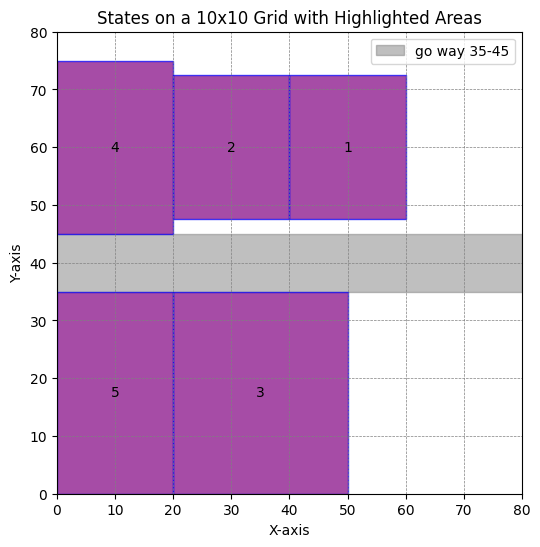

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Draw grid
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_xticks(range(0, 81, 10))
ax.set_yticks(range(0, 81, 10))
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Highlight vertical range 35 to 45
ax.axhspan(35, 45, color='gray', alpha=0.5, label='go way 35-45')


# Plot states as rectangles
for idx, (x, y, k, t) in enumerate(zip(x_values, y_values, k_values, t_values), start=1):
    # Calculate bottom-left corner from center
    bottom_left_x = x - k / 2
    bottom_left_y = y - t / 2

    # Create rectangle
    rect = patches.Rectangle((bottom_left_x, bottom_left_y), k, t, linewidth=1, edgecolor='blue', facecolor='purple', alpha=0.7)
    ax.add_patch(rect)

    # Add number to the center of the rectangle
    ax.text(x, y, str(idx), color='black', ha='center', va='center', fontsize=10)

# Labels and title
ax.set_title("States on a 10x10 Grid with Highlighted Areas")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

# Show legend
ax.legend(loc="upper right")

# Display the plot
plt.show()
